# Анализ результатов A/B-тестирования (новая платежная воронка)

**Задача**

Провести оценку результатов A/B-теста:
   * оценить корректность проведения теста;
   * проанализировать результаты теста.
   
**Исходные данные:**
   * 2 группы: 
       * А — контрольная, 
       * B — новая платёжная воронка;
   * дата запуска: 2020-12-07;
   * дата остановки набора новых пользователей: 2020-12-21;
   * дата остановки: 2021-01-04;
   * аудитория: 15% новых пользователей из региона EU;
   * назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
   * ожидаемое количество участников теста: 6000;
   * ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%
    
**Исходные датасеты:**

* календарь маркетинговых событий на 2020 год.
* пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.
* действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
* таблица участников тестов.


## План работ

1. [Шаг 1. Импорт и изучение данных](#step1)  
2. [Шаг 2. Предобработка данных](#step2)
3. [Шаг 3. Исследовательский анализ данных](#step3)
4. [Шаг 4. Проверка статистической разницы конверсий в группах](#step4)
5. [Шаг 5. Общий вывод](#step5)



## Глобальные настройки

**Импорты библиотек**

In [1]:
# Базовые библиотеки
import pandas as pd
import numpy as np

# Построение графиков 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

# Проверка статистических гипотез
from scipy import stats as st
import math as mth

**Настройки темы для графиков**

In [2]:
sns.set_style('whitegrid')
new = ['#FE022A', '#FF6302', '#02FBC3', '#46FE02']
sns.set_palette(new)

<a id='step1'></a>
## Импорт и изучение данных

In [3]:
marketing_events = pd.read_csv('ab_project_marketing_events.csv')
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
new_users =  pd.read_csv('final_ab_new_users.csv')
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [5]:
events = pd.read_csv('final_ab_events.csv')
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [6]:
participants = pd.read_csv('final_ab_participants.csv')
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [7]:
# Словарь таблиц
dfs = {'marketing_events' : marketing_events, 'new_users' : new_users, 
       'events' : events, 'participants' : participants}

In [8]:
# Проверка типов данных, пропусков и наличия грубых дубликатов для всех таблиц
for name, df in dfs.items():    
    print(name)
    print()
    print(df.info())
    print()
    print('Количество грубых дубликатов: {}'.format(df.duplicated().sum()))
    print()

marketing_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes
None

Количество грубых дубликатов: 0

new_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB
None

Количество грубых дубликатов: 0

events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None

К

In [9]:
# Проверка уникальных значений в столбцах таблиц
for name, df in dfs.items(): 
    print(name)
    print()
    for i in df.columns:
        print(i)
        print(df[i].unique())
    print()

marketing_events

name
['Christmas&New Year Promo' "St. Valentine's Day Giveaway"
 "St. Patric's Day Promo" 'Easter Promo' '4th of July Promo'
 'Black Friday Ads Campaign' 'Chinese New Year Promo'
 'Labor day (May 1st) Ads Campaign' "International Women's Day Promo"
 'Victory Day CIS (May 9th) Event' 'CIS New Year Gift Lottery'
 'Dragon Boat Festival Giveaway' "Single's Day Gift Promo"
 'Chinese Moon Festival']
regions
['EU, N.America' 'EU, CIS, APAC, N.America' 'N.America' 'APAC'
 'EU, CIS, APAC' 'CIS']
start_dt
['2020-12-25' '2020-02-14' '2020-03-17' '2020-04-12' '2020-07-04'
 '2020-11-26' '2020-01-25' '2020-05-01' '2020-03-08' '2020-05-09'
 '2020-12-30' '2020-06-25' '2020-11-11' '2020-10-01']
finish_dt
['2021-01-03' '2020-02-16' '2020-03-19' '2020-04-19' '2020-07-11'
 '2020-12-01' '2020-02-07' '2020-05-03' '2020-03-10' '2020-05-11'
 '2021-01-07' '2020-07-01' '2020-11-12' '2020-10-07']

new_users

user_id
['D72A72121175D8BE' 'F1C668619DFE6E65' '2E1BF1D4C37EA01F' ...
 '7ADEE837D5D8CBB

Исходя из первичного осмотра данных, можно сделать следующие выводы:
1. пропуски и грубые дубликаты в данных отсутствуют, за исключение столбца `details` таблицы `events`, что некритично, т.к. это необязательный параметр, и не по всем записям хранятся дополнительные данные о событии;
2. необходимо привести даты в таблицах `marketing_events`, `new_users`, `events`, `participants` к типу данных `datetime64`;
3. из таблицы `marketing_events` необходимо выбрать только те события, которые соответствуют региону (`EU`) и датам проведения (`2020-12-07` - `2021-01-04`) AB-теста;
4. в таблицу `new_users` попали пользователи, несоответствующие ТЗ AB-теста: необходимо выбрать только тех пользователей, которые соответствуют региону (`EU`) и временному периоду набора новых пользователей (`2020-12-07` - `2020-12-21`);
5. в таблице `participants` необходимо оставить только пользователей, относящихся к тесту `recommender_system_test`;
6. в таблице `events` необходимо из столбца `event_dt` выделить дату события.

<a id='step2'></a>
## Предобработка данных

**Обработка дат**

Приведем все даты к типу `datetime64`.

In [10]:
# Приведение всех дат во всех табицах к типу datetime64
for name, df in dfs.items():
    for i in df.columns:
        if 'dt' in i or 'date' in i:
            df[i] = pd.to_datetime(df[i])
    display(df.head())
    print(df.info())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null datetime64[ns]
finish_dt    14 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null datetime64[ns]
region        61733 non-null object
device        61733 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
None


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null datetime64[ns]
event_name    440317 non-null object
details       62740 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB
None


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB
None


Выделим дату события из столбца `event_dt` таблицы `events`.

In [11]:
events['date'] = events['event_dt'].dt.date
events['date'] = pd.to_datetime(events['date'])
events.sample(5)

,user_id,event_dt,event_name,details,date
103812,84E9BDB45E5595A8,2020-12-21 16:15:00,product_cart,NaN,2020-12-21
115254,0B575735D9892FED,2020-12-24 12:11:20,product_cart,NaN,2020-12-24
311231,B57D15DDF01BFA90,2020-12-15 00:47:03,login,NaN,2020-12-15
163733,CBCB434A80BE255A,2020-12-15 20:24:46,product_page,NaN,2020-12-15
84279,3B73C7C49821DD35,2020-12-15 16:27:20,product_cart,NaN,2020-12-15


In [12]:
# Разброс значений дат в таблице
events['date'].describe()

count                  440317
unique                     24
top       2020-12-21 00:00:00
freq                    32559
first     2020-12-07 00:00:00
last      2020-12-30 00:00:00
Name: date, dtype: object

**Фильтрция данных в таблице `marketing_events`**

Выделим маркетинговые события, которые проходили в период проведения AB-теста.

In [13]:
ab_marketing_events = marketing_events[(marketing_events['start_dt'] >= '2020-12-07') 
                                       & (marketing_events['finish_dt'] <= '2021-01-04') 
                                       & (marketing_events['regions'].str.contains('EU'))]
ab_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


**Фильтрция данных в таблице `new_users`**

Выделим пользователей региона `EU`, чьи даты соответствуют датам набора новых пользователей (`2020-12-07` - `2020-12-21`).

In [14]:
ab_users = new_users[(new_users['first_date'] >= '2020-12-07')
                     & (new_users['first_date'] <= '2020-12-21')
                     & (new_users['region'] == 'EU')]
ab_users.sort_values(by = 'first_date', ascending = True).tail()

,user_id,first_date,region,device
13316,97E7AB0A787DCE46,2020-12-21,EU,iPhone
13315,662E8A4E0F1C1382,2020-12-21,EU,Android
13314,16FF2E767374D4AB,2020-12-21,EU,Android
13282,668A8E82618D438E,2020-12-21,EU,Android
14098,2C52C977465888B7,2020-12-21,EU,iPhone


**Фильтрция данных в таблице `participants`**

In [15]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [16]:
ab_participants = participants.query('ab_test == "recommender_system_test"')
ab_participants.tail()

,user_id,group,ab_test
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test
6700,6715343AFBA285AE,B,recommender_system_test


In [17]:
ab_participants['ab_test'].unique()

array(['recommender_system_test'], dtype=object)

Проверим, есть ли пользователи, которые одновременно участвовали в тесте `recommender_system_test` и во втором тесте `interface_eu_test` одновременно.

In [18]:
# Идентификаторы пользователей, участвующих в двух тестах одновременно
intersected_users = ab_participants['user_id'][ab_participants['user_id'].isin(participants.query('ab_test == "interface_eu_test"')['user_id'])]

# Количество пользователей, участвующих в двух тестах одновременно
len(intersected_users)

1602

In [19]:
# Доля пользователей, участвующих в двух тестах одновременно, от числа участников теста 
len(intersected_users) / len(ab_participants)

0.23906879570213402

**Вывод**

Была выполнена первичная предобработка данных: 
1. Все даты во всех таблицах были приведены к формату даты (тип данных `datetime64`).
2. Были отфильтрованы данные во всех таблицах в соответствии с ТЗ AB-теста.  
Отфильтрованные данные были записаны в таблицы `ab_marketing_events`, `ab_users` и `ab_participants`.

В ходе предобработки данных:
* было обнаружено 1602 пользователя, которые участвовали одновременно в двух проводимых AB-тестах (`recommender_system_test` и `interface_eu_test`), что составляет 24% от всех участников теста `recommender_system_test`. Поведение пользователей, одновременно участвующих в двух тестах одновременно, будет сложно интерпретировать, т.к. непонятно, изменения из какого теста повлияли на пользователей.

<a id='step3'></a>
## Исследовательский анализ данных

### Участники теста

Проверим корректное разделение пользователей на группы, а также отсеем пользователей, которые не попадают в обозначенные в ТЗ временные сроки.

In [20]:
# Исходное количество пользователей в таблице с учатниками
ab_participants['user_id'].nunique()

6701

In [21]:
# Количество пользователей, записи по которым есть более чем в одной экспериментальной группе
sum(ab_participants.groupby('user_id')['group'].nunique() > 1)

0

Смержим участников АБ-теста с таблицей с новыми пользователями из региона EU, зарегистрированными в интересующий нас интервал времени. Оставим только тех пользователей, которые есть в обоих таблицах.

In [22]:
ab_participants = ab_participants.merge(ab_users, on = 'user_id', how = 'inner')
# Длина таблицы после мержа
len(ab_participants)

6351

Можно отметить, что количество участников уменьшилось. Скорее всего, в таблицу с участниками попали пользователи из других регионов, либо которые зарегестрировались вне заданного временного интервала.

Проверим размерность экспериментальных групп.

In [23]:
# Размерность экспериментальных групп
participants_info = ab_participants['group'].value_counts().to_frame()
participants_info['rate'] = round(participants_info['group'] / participants_info['group'].sum(), 2)
participants_info

,group,rate
A,3634,0.57
B,2717,0.43


**Вывод**  

Количество участников соответствует ТЗ, в то время как качество разбиения пользователей на группы для теста не очень хорошее: количество пользователей в экспериментальных группах различается на 14%, также в таблицу с участниками попали пользователи, не соответствующие ТЗ AB-теста (из других регионов, зарегистрированные в даты, выходящие за обозначенный интервал).
Некорректность разделения на группы может сказаться на результатах, полученных в ходе проведения AB-теста.

### События

**Фильтрация событий**

Оставим в таблице с событиями информацию только по участникам AB-теста.

In [24]:
# Длина исходной таблицы с событиями
len(events)

440317

In [25]:
# Список с идентификаторов участников
list_of_participants = ab_participants['user_id'].unique()

In [26]:
# Срез данных по участникам AB-теста
events = events.query('user_id in @list_of_participants')
# Итоговая длина таблицы с событиями
len(events)

23420

Итого у нас имеется 23 420 событий в логах по участникам AB-теста.   
Изучим их подробнее.

**Даты событий**

Проверим интервал дат событий в таблицы

In [27]:
# Даты проведения теста
events['date'].describe()

count                   23420
unique                     24
top       2020-12-21 00:00:00
freq                     2304
first     2020-12-07 00:00:00
last      2020-12-30 00:00:00
Name: date, dtype: object

Временные границы проведения AB-теста по ТЗ: `2020-12-07` - `2021-01-04`. Однако в таблице с событиями содержатся данные только до `2020-12-30`. Либо по пользователям отсутствуют данные за первые числа января, либо данные в таблице неполные.

Проверим, пересекаются ли даты проведения маркетинговых кампаний `ab_marketing_events`  с датами событий в логах `events`.

In [28]:
ab_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Видно, что даты одной маркетинговой акции пересекаются с датами проведения AB-теста. Данная акция может повлиять на поведение пользователей, что может исказить результаты AB-теста.

**Количество событий**

**Распределение количества событий по датам**

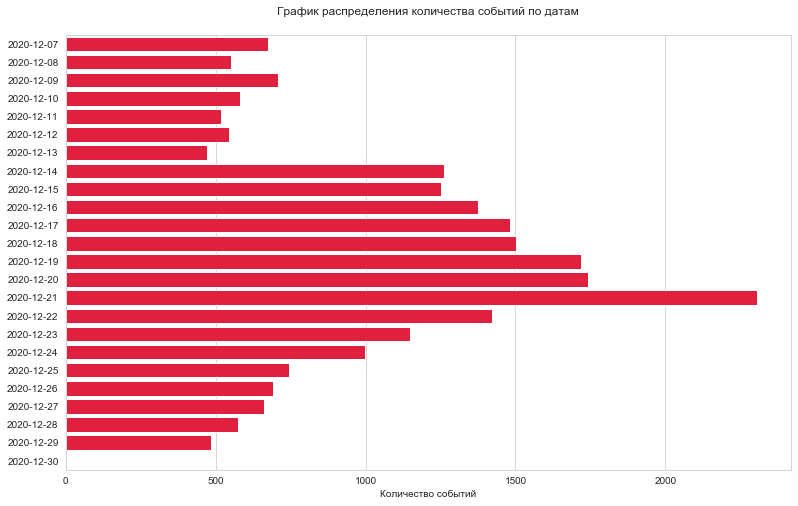

In [29]:
# Построение графика распределения количества событий по датам
plt.figure(figsize=(13, 8))

ax = sns.countplot(data = events, y = 'date', color = new[0])

# Настройка графика
plt.title('График распределения количества событий по датам', pad = 20)
plt.xlabel('Количество событий')
plt.ylabel('')
ax.set_yticklabels(pd.Series(events['date'].unique()).dt.date)

plt.show()

Количество событий по дням распределено не равномерно: можно отметить резкий рост в количестве событий начиная с 14 декабря, пик приходится на 21 декабря, после чего идет существенный спад в количестве событий. Такое неравномерное распределение данных можно связать с предрождественским периодом: на неделю перед Рождеством приходится резкий рост в количестве событий. 

**Распределение событий по количеству записей в логе**

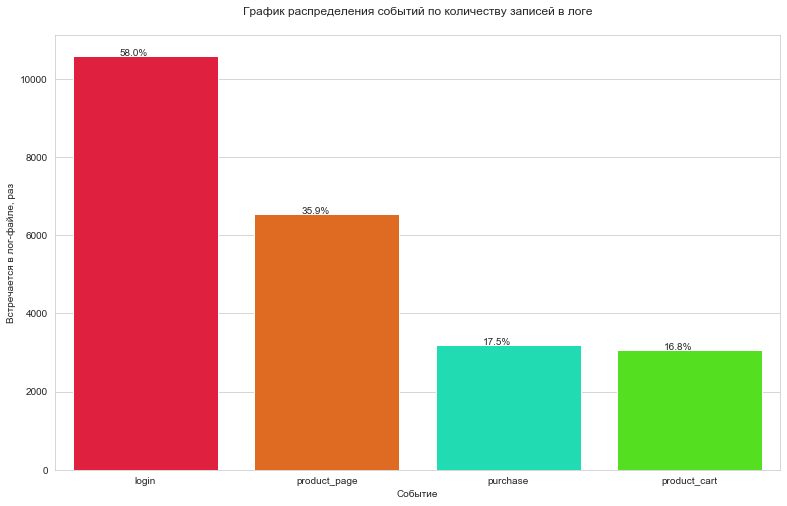

In [30]:
# Построение графика распределения событий по количеству записей в логе

# Настройки фигуры 
plt.figure(figsize=(13, 8))

ax = sns.countplot(data = events, 
                   x = 'event_name',
                   order = events['event_name'].value_counts().index, palette = new);

# Процентное соотношение
total = len(df)
for p in ax.patches:
        percentage = '{:.1%}'.format(p.get_height()/total)
        x = p.get_x() + p.get_width()/3.1
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))

# Настройка графика
plt.title('График распределения событий по количеству записей в логе', pad = 20)
plt.xlabel('Событие')         
plt.ylabel('Встречается в лог-файле, раз')


plt.show()

**Распределение количества событий по группам участников теста**

Добавим в таблицу `events` информацию по экспериментальной пользовательской группе.

In [31]:
events = events.merge(ab_participants[['user_id', 'group']], on = 'user_id', how = 'left')
events.head()

,user_id,event_dt,event_name,details,date,group
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,A
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,B
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,A
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,B


In [32]:
# Проверка, всем ли пользователям проставилась группа
events['group'].unique()

array(['A', 'B'], dtype=object)

In [33]:
print('Количество событий по пользователей группы A:', len(events[events['group'] == 'A']))
print('Количество событий по пользователей группы B:', len(events[events['group'] == 'B']))
print('Количество уникальных пользователей, совершивших событие, разбитое по экспериментальным группам:')
display(events.pivot_table(columns = 'group', index = 'event_name', values = 'user_id', aggfunc = 'nunique'))

Количество событий по пользователей группы A: 18309
Количество событий по пользователей группы B: 5111
Количество уникальных пользователей, совершивших событие, разбитое по экспериментальным группам:


group,A,B
event_name,,
login,2604,877
product_cart,782,244
product_page,1685,493
purchase,833,249


Распределений событий по экспериментальным группам неравномерное. Количество событий по пользователям в группе A более чем в три раза превышает количество событий по пользователям в группе B. Такой разброс в данных может сильно сказаться на качестве результатов AB теста.

**Количество пользователей по событиями**

Проверим, по всем ли участникам AB-теста есть записи по событиям.

In [34]:
# Количество уникальных пользователей, по которым есть записи в таблице с событиями
events['user_id'].nunique()

3481

In [35]:
# Распределение пользователей по группам
events.groupby('group')['user_id'].nunique()

group
A    2604
B     877
Name: user_id, dtype: int64

Количество пользователей, по которым есть записи в логе событий почти в два раза меньше, чем количество участников AB теста (из таблицы `ab_participants`), количество пользователей по группам распределено неравномерно: в группе A более чем в 3 раза больше, чем в группе B.

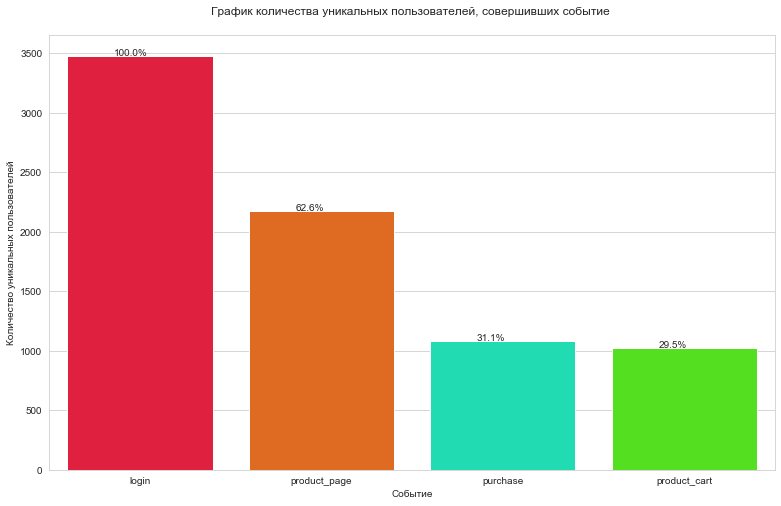

In [36]:
# График количества уникальных пользователей, совершивших то или иное действие (событие)

# Настройки фигуры 
plt.figure(figsize=(13, 8))

# Количество уникальных пользователей, совершивших действия
events_by_user = events.groupby('event_name', as_index = False).agg({'user_id' :'nunique'}).sort_values(by = 'user_id', ascending = False)

ax = sns.barplot(data = events_by_user, 
                 x = 'event_name',
                 y = 'user_id');

# Процентное соотношение
total = events['user_id'].nunique()
for p in ax.patches:
        percentage = '{:.1%}'.format(p.get_height()/total)
        x = p.get_x() + p.get_width()/3.1
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))

# Настройка графика
plt.title('График количества уникальных пользователей, совершивших событие ', pad = 20)
plt.xlabel('Событие')         
plt.ylabel('Количество уникальных пользователей')


plt.show()

### Продуктовые воронки событий

Исходя из построенного выше графика можно сделать вывод, что 100% пользователей начинают с действия `login`, после чего переходят на страницу/экран с товаром (`product_page`). 
Количество пользователей, совершающих действие покупки `purchase` превышает количество пользователей, совершающих переход на страницу/экран с корзиной (`product_cart`). Cкорее всего, для оформления заказа и покупки товара не обязательно переходить на страницу с корзиной.   
В связи с этим рассмотрим 3 продуктовые воронки для двух экспериментальных групп: продуктовую воронку без учета последовательностей событий для всех событий, продуктовую воронку с учетом последовательности событий для всех событий и продуктовую воронку с учетом последовательности событий без события `product_cart`.

Продуктовая воронка полная: 

    Login  
      ↓   
    Product_page 
      ↓
    Product_cart
       ↓
    Purchase 
    
Продуктовая воронка без учета события `product_cart`: 

    Login  
      ↓   
    Product_page 
      ↓
    Purchase 

#### Воронка без учета последовательностей событий

In [37]:
# Воронка для событий группы A

# Количество уникальных пользователей, совершивших событие
funnel_1_a = events[events['group'] == 'A'].groupby('event_name', as_index = False).agg({'user_id' :'nunique'})
funnel_1_a = funnel_1_a.sort_values(by = 'user_id', ascending = False)

# Расчет доли пользователей, совершивших действие, от числа уникальных пользователей на первом шаге
funnel_1_a['ratio_from_first'] = round((funnel_1_a['user_id'] / funnel_1_a['user_id'][0]).fillna(1), 2)

In [38]:
# Воронка для событий группы B

# Количество уникальных пользователей, совершивших событие
funnel_1_b = events[events['group'] == 'B'].groupby('event_name', as_index = False).agg({'user_id' :'nunique'})
funnel_1_b = funnel_1_b.sort_values(by = 'user_id', ascending = False)

# Расчет доли пользователей, совершивших действие, от числа уникальных пользователей на первом шаге
funnel_1_b['ratio_from_first'] = round((funnel_1_b['user_id'] / funnel_1_b['user_id'][0]).fillna(1), 2)

In [39]:
print('Воронка для событий группы A')
display(funnel_1_a)
print()
print('Воронка для событий группы B')
display(funnel_1_b)

Воронка для событий группы A


,event_name,user_id,ratio_from_first
0,login,2604,1.00
2,product_page,1685,0.65
3,purchase,833,0.32
1,product_cart,782,0.30



Воронка для событий группы B


,event_name,user_id,ratio_from_first
0,login,877,1.00
2,product_page,493,0.56
3,purchase,249,0.28
1,product_cart,244,0.28


Показатели долей пользователей, совершивших действие, от числа уникальных пользователей на первом шаге, для группы B ниже, чем для группы A по всем событиям.

#### Воронки с учетом последовательностей  событий

In [40]:
# Функция построения воронки, в flag передаются значения:
#'yes' - воронка с событием product_cart
#'no' - воронка без учета события product_cart

def create_funnel(df, flag):
    # Расчет времени первого действия, совершенного пользователем
    first_events = df.pivot_table(index = 'user_id', columns = 'event_name', 
                                      values = 'event_dt', aggfunc = 'min')

    # Список пользователей, совершивших действие 'login'
    step_1 = ~first_events['login'].isnull()

    # Список пользователей, совершивших действие 'product_page' после действия 'login'
    step_2 = step_1 & (first_events['product_page'] >= first_events['login'])

    if flag == 'yes':
        # Список пользователей, совершивших действие 'product_cart' после действия 'product_page'
        step_3 = step_2 & (first_events['product_cart'] >= first_events['product_page'])
        # Список пользователей совершивших действие 'purchase' после действия 'product_cart'
        step_4 = step_3 & (first_events['purchase'] >= first_events['product_cart'])
        # Подсчет количества пользователей для событий
        login = len(first_events[step_1])
        product_page = len(first_events[step_2])
        product_cart = len(first_events[step_3])
        purchase = len(first_events[step_4])
        # Сохранение данных в таблицу 
        data = {'event_name':['Логин', 'Страница с продуктом', 'Продуктовая корзина', 'Покупка'], 
                'users_count':[login, product_page, product_cart, purchase]}   
    
    if flag == 'no':
        # Список пользователей, совершивших действие 'purchase' после действия 'product_page'
        step_3 = step_2 & (first_events['purchase'] >= first_events['product_page'])
        # Подсчет количества пользователей для событий
        login = len(first_events[step_1])
        product_page = len(first_events[step_2])
        purchase = len(first_events[step_3])
        # Сохранение данных в таблицу 
        data = {'event_name':['Логин', 'Страница с продуктом', 'Покупка'], 
                'users_count':[login, product_page, purchase]}
    
    
    funnel = pd.DataFrame(data)
    
    # Расчет доли пользователей, совершивших действие, от числа уникальных пользователей на предыдущем шаге
    funnel['ratio_from_prev'] = round((funnel['users_count'] / funnel['users_count'].shift(1)).fillna(1), 2)
    return funnel

In [41]:
funnel_2_a = create_funnel(events[events['group'] == 'A'], 'yes')
funnel_2_b = create_funnel(events[events['group'] == 'B'], 'yes')
funnel_3_a = create_funnel(events[events['group'] == 'A'], 'no')
funnel_3_b = create_funnel(events[events['group'] == 'B'], 'no')

In [42]:
print('Воронка с учетом последовательности событий')
print('Login -> Product_page -> Product_cart -> Purchase')
print()
print('для группы A')
display(funnel_2_a)
print()
print('для группы B')
display(funnel_2_b)
print()
print()
print('Воронка с учетом последовательности событий')
print('Login -> Product_page -> Purchase')
print()
print('для группы A')
display(funnel_3_a)
print()
print('для группы B')
display(funnel_3_b)
print()

Воронка с учетом последовательности событий
Login -> Product_page -> Product_cart -> Purchase

для группы A


,event_name,users_count,ratio_from_prev
0,Логин,2604,1.00
1,Страница с продуктом,1685,0.65
2,Продуктовая корзина,369,0.22
3,Покупка,41,0.11



для группы B


,event_name,users_count,ratio_from_prev
0,Логин,877,1.00
1,Страница с продуктом,493,0.56
2,Продуктовая корзина,100,0.20
3,Покупка,10,0.10




Воронка с учетом последовательности событий
Login -> Product_page -> Purchase

для группы A


,event_name,users_count,ratio_from_prev
0,Логин,2604,1.00
1,Страница с продуктом,1685,0.65
2,Покупка,245,0.15



для группы B


,event_name,users_count,ratio_from_prev
0,Логин,877,1.00
1,Страница с продуктом,493,0.56
2,Покупка,73,0.15


Изучив продуктовые воронки, можно предположить, что показатели (конверсии в события `product_page`, `product_cart` и `purchase`) для группы B хуже, чем для группы A. 

### Вывод

В ходе проведения исследовательского анализа данных был обнаружен ряд нарушений в проведении AB-теста:
* неравномерное распределение пользователей и событий между группами;
* проведение маркетинговых кампаний в даты сбора тестовых данных;
* неполные данные в таблице `events`.

Также были изучены продуктовые воронки для двух групп теста без учета последовательности событий, а также с учетом последовательности событий:
* предварительно, группа B показала себя хуже по всем показателя, чем группа A (но количество пользователей в группе B в три раза меньше, чем в группе A);
* пользовательский путь нечетко определен, пользователи могут пропускать разные этапы воронки: например, не всегда перед совершением покупки (событие `purchase`) пользователи переходят в продуктовую корзину (событие `product_cart`).

<a id='step4'></a>
## Проверка статистической разницы конверсий в группах

### Подготовка данных

Подготовим таблицу по группам, где будет информация об общем количестве пользователей в группе и о количестве пользователей, совершивших событие, а также долю таких пользователей. Т.к. ранее было установлено, проход по всем этапам воронки не является обязательным условием, смотреть конверсию будем относительно общего числа клиентов.

In [43]:
# Таблица с количеством уникальных пользователей по группам и событиям
groups_by_events = events.groupby(['group', 'event_name'], as_index = False).agg({'user_id':'nunique'})
groups_by_events.head()

,group,event_name,user_id
0,A,login,2604
1,A,product_cart,782
2,A,product_page,1685
3,A,purchase,833
4,B,login,877


In [44]:
# Cрезы по каждой группе эксперимента
group_a = events.query('group == "A"')
group_b = events.query('group == "B"')

In [45]:
# Словарь с количеством уникальных пользователей по группам
groups_count_dict = {'A': group_a['user_id'].nunique(),
                     'B': group_b['user_id'].nunique()}

In [46]:
# Добавление нового столбца с количеством пользователей в группе
# в соответствии с маппингом группа/количество пользователей

groups_by_events['total'] = groups_by_events['group'].map(groups_count_dict)

In [47]:
# Конверсия в событие от общего числа пользователей в группе
groups_by_events['ratio_from_total'] = groups_by_events['user_id'] / groups_by_events['total']

In [48]:
# Итоговая таблица
groups_by_events

,group,event_name,user_id,total,ratio_from_total
0,A,login,2604,2604,1.000000
1,A,product_cart,782,2604,0.300307
2,A,product_page,1685,2604,0.647081
3,A,purchase,833,2604,0.319892
4,B,login,877,877,1.000000
5,B,product_cart,244,877,0.278221
6,B,product_page,493,877,0.562144
7,B,purchase,249,877,0.283922


### Функция Z-теста

Задачу сравнения и определения статистической значимости между двумя генеральными совокупностями на основе пропорций в выборках будем решать с помощью Z-теста.


<center><b>Z - критерий:
<p>   

$$Z \approx \frac{P_{1} - P_{2}}{(1 - P)(1/n_{1} + 1/n_{2})}$$

In [49]:
def z_test(event, group1, group2):
   
    # срез данных по событию воронки продаж
    event_slice = groups_by_events[(groups_by_events['event_name'] == event)]

    # конверсия в первой группе от числа уникальных пользователей группы
    p1 = event_slice[event_slice['group'] == group1]['ratio_from_total'].values[0]
    # количество уникальных пользователей первой группы
    n1 = event_slice[event_slice['group'] == group1]['total'].values[0]

    # конверсия во второй группе от числа уникальных пользователей группы
    p2 = event_slice[event_slice['group'] == group2]['ratio_from_total'].values[0]
    # количество уникальных пользователей второй группы
    n2 = event_slice[event_slice['group'] == group2]['total'].values[0]

    # разница конверсий 
    dif = p1 - p2

    # конверсия в комбинированном датасете:
    p_combined = (
    (event_slice[event_slice['group'] == group1]['user_id'].values[0] +
     event_slice[event_slice['group'] == group2]['user_id'].values[0]) / 
    (event_slice[event_slice['group'] == group1]['total'].values[0] +
     event_slice[event_slice['group'] == group2]['total'].values[0])
    )

    # расчет z-критерия
    z_value = dif / mth.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))

    # стандартное нормальное распределение
    distr = st.norm(0, 1)
    
    # расчет p-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    # задаем уровень стат.значимости
    alpha = 0.05

    if (p_value < alpha):
        print('Между конверсиями в событие {} группы {} и группы {} есть значимая разница'.format(event, group1, group2))
    else:
        print('Нет оснований считать конверсии в событие {} групп {} и {} разными'.format(event, group1, group2))

### Сравнение конверсий в группах по событиям

In [50]:
# Список с уникальными названиями событий, за исключением события login
event_name_dict = groups_by_events['event_name'].unique()[1:]
event_name_dict

array(['product_cart', 'product_page', 'purchase'], dtype=object)

In [51]:
# Применение z-теста ко всем событиям (за ислючением события login) для групп A и B
for i in event_name_dict:
    print('Событие', i)
    z_test(i, 'A', 'B')
    print()

Событие product_cart
p-значение:  0.21469192029582396
Нет оснований считать конверсии в событие product_cart групп A и B разными

Событие product_page
p-значение:  6.942739359416805e-06
Между конверсиями в событие product_page группы A и группы B есть значимая разница

Событие purchase
p-значение:  0.04652482738393027
Между конверсиями в событие purchase группы A и группы B есть значимая разница



<a id='step5'></a>
## Общий вывод

По результатам проведения анализа данных, собранных в ходе проведения AB-теста, можно сделать вывод, что конверсия в события `product_page`, `product_cart` и `purchase` в группе B хуже, чем в группе A. Причем различия между конверсиями в события `product_page` и `purchase ` статистически значимы, т.е. изменения, связанные с внедрением улучшенной рекомендательной системы, себя не оправдали, и новая платежная воронка показывает себя хуже.

Однако был зафиксирован ряд грубых нарушений в процессе проведения теста, а именно:
1. Неравномерное разбиение пользователей (участников) на группы (в группе A уникальных пользователей в 3 раза больше, чем в группе B), соответственно и количество событий распределено между группами неравномерно.
2. Участие 24% пользователей одновременно во втором проводимом AB-тесте `interface_eu_test`.
3. Итоговое количество участников теста почти в 2 раза меньше, чем было запланировано изначально (~3500 против 6000).
4. В таблице с событиями есть данные только за период с 07.12.2020 по 30.12.2020, тогда как планируемый период для теста был определен с 07.12.2020 по 04.01.2021.
5. Неудачный период для поведения теста: даты поведения теста попадают под рождественские и новогодние праздники: поведение покупателей в эти даты всегда меняется и не отражает реальной картины событий. Также в даты сбора тестовых данных проводилась маркетинговая кампания Christmas&New Year Promo  (c 25.12.2020 по 03.01.2021), которая могла повлиять на поведение определенных пользователей той или иной группы, а сведения о том, какие пользователи попали под действие данной акции, отсутствуют.  

(!) В связи с выявленными нарушениями быть уверенными в достоверности сделанных выводов нельзя, поэтому нет оснований считать группу B хуже группы A. Необходимо заново провести тест, выбрав более подходящий период (без влияния сезонных события и маркетинговых кампаний), а также предварительно проведя AA-тест для проверки корректности работы инструмента разбиения пользователей на группы.
